In [0]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D, Dropout, Softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle as pkl
import matplotlib.pyplot as plt


In [0]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D, Dropout
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle as pkl
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
!wget "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camel.npy"

--2019-12-29 09:03:49--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camel.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95176896 (91M) [application/octet-stream]
Saving to: ‘camel.npy’

camel.npy           100%[===================>]  90.77M  69.9MB/s    in 1.3s    

2019-12-29 09:03:51 (69.9 MB/s) - ‘camel.npy’ saved [95176896/95176896]



In [0]:
data = np.load("camel.npy")
data = data.reshape(data.shape[0], 28, 28, 1)

In [0]:
class WGAN():

    def  __init__(self, 
                  input_dim,
                  disc_filter,
                  disc_kernel,
                  disc_strides,
                  disc_dropout,
                  disc_lr,
                  gen_filter,
                  gen_kernel,
                  gen_strides,
                  gen_upsample,
                  gen_lr,
                  z_dim,
                  batch_size):
      

          self.input_dim = input_dim
          self.disc_filter = disc_filter
          self.disc_kernel = disc_kernel
          self.disc_strides = disc_strides
          self.disc_dropout = disc_dropout
          self.disc_lr = disc_lr
          self.gen_filter = gen_filter
          self.gen_kernel = gen_kernel
          self.gen_strides = gen_strides
          self.gen_upsample = gen_upsample
          self.gen_lr = gen_lr
          self.z_dim = z_dim
          self.batch_size = batch_size

          self.d_losses = []
          self.g_losses = []
          self.epoch = 0

          self.Discriminator()
          self.Generator()

          self.full_model()

    def wasserstein(self, y_true, y_pred):
        return -K.mean(y_true * y_pred)

    def Discriminator(self):

        disc_input = Input(shape=self.input_dim, name='discriminator_input')
        x = disc_input

        for i in range(len(self.disc_filter)):
            x = Conv2D(filters=self.disc_filter[i], kernel_size=self.disc_kernel[i], strides=self.disc_strides[i], padding='same', name='disc_'+str(i))(x)
            x = LeakyReLU()(x)
            x = Dropout(self.disc_dropout)(x)
            x = BatchNormalization()(x)

        x = Flatten()(x)
        disc_output = Dense(1, activation="linear")(x)
        self.discriminator = Model(disc_input, disc_output)

    def Generator(self):

        gen_input = Input(shape=(self.z_dim,), name='generator_input')
        x = gen_input

        x = Dense(7*7*self.batch_size)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        x = Reshape(target_shape=(7,7,self.batch_size))(x)
        
        for i in range(len(self.gen_filter)):
            if self.gen_upsample[i]==2:
                x = UpSampling2D(size=self.gen_upsample[i], name='upsample_'+str(i/2))(x)
                x = Conv2D(filters=self.gen_filter[i], kernel_size=self.gen_kernel[i], strides=self.gen_strides[i], padding='same', name='gen_'+str(i))(x)

            else:
                x = Conv2DTranspose(filters=self.gen_filter[i], kernel_size=self.gen_kernel[i], strides=self.gen_strides[i], padding='same', name='gen_'+str(i))(x)
            
            if i<len(self.gen_filter)-1:
                #x = BatchNormalization()(x)
                x = LeakyReLU()(x)

            else:
                x = Activation("tanh")(x)

        gen_output = x
        self.generator = Model(gen_input, gen_output)

      
    def set_trainable(self, model, val):
        model.trainable=val
                  
    def full_model(self):
        
        ### COMPILE DISCRIMINATOR
        self.discriminator.compile(optimizer= Adam(self.disc_lr), loss = self.wasserstein, metrics=['accuracy'])
    
        ### COMPILE THE FULL GAN

        self.set_trainable(self.discriminator, False)
        self.discriminator.compile(optimizer= Adam(self.disc_lr), loss = self.wasserstein, metrics=['accuracy'])

        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.discriminator(self.generator(model_input))
        self.model = Model(model_input, model_output)

        self.model.compile(optimizer= Adam(self.disc_lr), loss = self.wasserstein, metrics=['accuracy'])

        self.set_trainable(self.discriminator, True)

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)

    def train_discriminator(self, x_train, batch_size, using_generator):
        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))
        
        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real, d_acc_real =  self.discriminator.train_on_batch(true_imgs, valid)
        d_loss_fake, d_acc_fake =  self.discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        for l in self.discriminator.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -0.01, 0.01) for w in weights]
            l.set_weights(weights)

        return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

    def train(self, x_train, batch_size, epochs, print_every_n_batches = 50, using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            d = self.train_discriminator(x_train, batch_size, using_generator)
            g = self.train_generator(batch_size)
            if self.epoch % print_every_n_batches == 0:
                print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

            self.d_losses.append(d)
            self.g_losses.append(g)

            self.epoch+=1

In [0]:
wgan = WGAN(input_dim = (28,28,1)
        , disc_filter = [64,64,128,128]
        , disc_kernel = [5,5,5,5]
        , disc_strides = [2,2,2,1]
        , disc_dropout = 0.4
        , disc_lr = 0.0008
        , gen_upsample = [2,2, 1, 1]
        , gen_filter = [128,64, 64,1]
        , gen_kernel = [5,5,5,5]
        , gen_strides = [1,1, 1, 1]
        , gen_lr = 0.0004
        , z_dim = 100
        , batch_size=64
        )





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.











In [0]:
wgan.discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
disc_0 (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
disc_1 (Conv2D)              (None, 7, 7, 64)          102464    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0   

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
wgan.generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
upsample_0.0 (UpSampling2D)  (None, 14, 14, 64)        0         
_________________________________________________________________
gen_0 (Conv2D)               (None, 14, 14, 128)       2049

In [0]:
wgan.model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         843137    
_________________________________________________________________
model_1 (Model)              (None, 1)                 722369    
Total params: 843,905
Trainable params: 836,865
Non-trainable params: 7,040
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
BATCH_SIZE = 64
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 10

In [0]:
wgan.train(     
    data
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



0 [D loss: (0.088)(R 0.175, F -0.000)] [D acc: (0.258)(0.234, 0.281)] [G loss: 0.000] [G acc: 0.000]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10 [D loss: (0.000)(R 0.000, F -0.000)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.000] [G acc: 0.000]
20 [D loss: (0.000)(R 0.000, F -0.000)] [D acc: (0.500)(0.000, 1.000)] [G loss: -0.000] [G acc: 0.000]
30 [D loss: (0.000)(R 0.000, F -0.000)] [D acc: (0.500)(0.000, 1.000)] [G loss: -0.000] [G acc: 0.000]
40 [D loss: (-0.000)(R -0.000, F -0.000)] [D acc: (0.500)(0.000, 1.000)] [G loss: -0.000] [G acc: 0.000]
50 [D loss: (-0.000)(R -0.000, F -0.000)] [D acc: (0.500)(0.000, 1.000)] [G loss: -0.000] [G acc: 0.000]
60 [D loss: (-0.000)(R -0.000, F -0.000)] [D acc: (0.500)(0.000, 1.000)] [G loss: -0.000] [G acc: 0.000]
70 [D loss: (-0.000)(R -0.000, F -0.000)] [D acc: (0.500)(0.000, 1.000)] [G loss: -0.000] [G acc: 0.000]
80 [D loss: (-0.000)(R -0.000, F -0.000)] [D acc: (0.500)(0.000, 1.000)] [G loss: -0.000] [G acc: 0.000]
90 [D loss: (-0.000)(R -0.000, F -0.000)] [D acc: (0.500)(0.000, 1.000)] [G loss: -0.000] [G acc: 0.000]


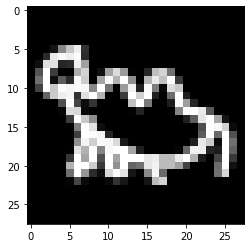

In [0]:
plt.imshow(data[0].reshape(28,28), interpolation='nearest', cmap='gray')
plt.show()

In [0]:
noise = np.random.normal(0, 1, (64, 100))
arr = wgan.generator.predict(noise)

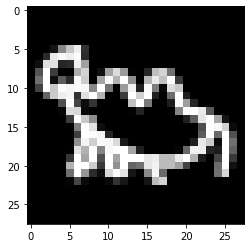

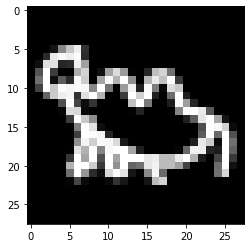

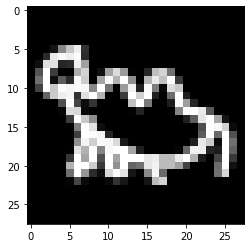

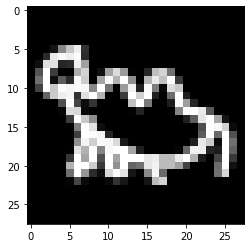

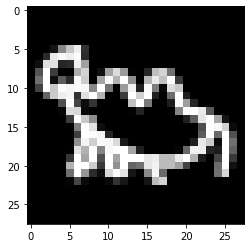

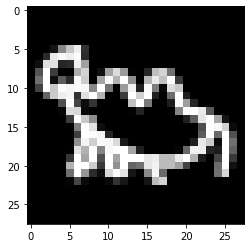

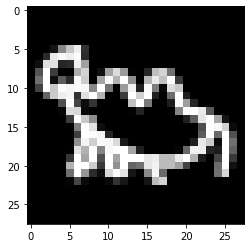

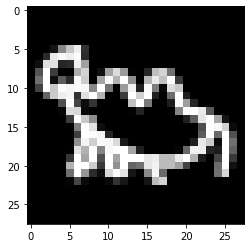

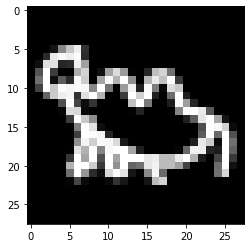

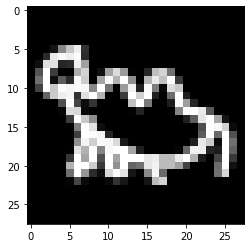

In [0]:
for img in arr[:10]:
    plt.imshow(data[0].reshape(28,28), interpolation='nearest', cmap='gray')
    plt.show()

In [0]:
for l in wgan.discriminator.layers:
  print(l.get_config()['name'])

discriminator_input
disc_0
leaky_re_lu_45
dropout_25
batch_normalization_30
disc_1
leaky_re_lu_46
dropout_26
batch_normalization_31
disc_2
leaky_re_lu_47
dropout_27
batch_normalization_32
disc_3
leaky_re_lu_48
dropout_28
batch_normalization_33
flatten_7
dense_11
